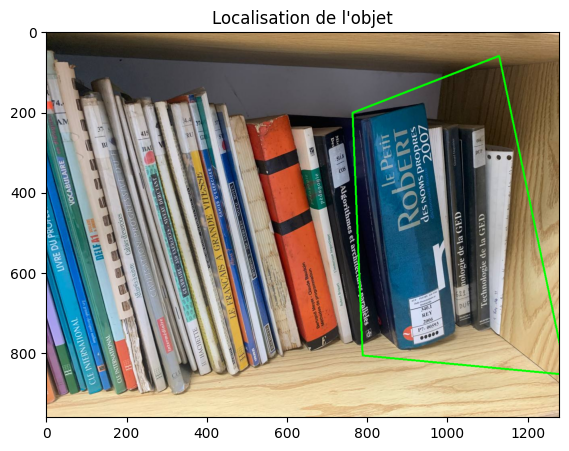

FileNotFoundError: [Errno 2] No such file or directory: 'train_images'

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

def detect_and_match_sift(image_obj, image_scene):
    gray_obj = cv2.cvtColor(image_obj, cv2.COLOR_BGR2GRAY)
    gray_scene = cv2.cvtColor(image_scene, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints_obj, descriptors_obj = sift.detectAndCompute(gray_obj, None)
    keypoints_scene, descriptors_scene = sift.detectAndCompute(gray_scene, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_obj, descriptors_scene, k=2)

    good_matches = []
    ratio_threshold = 0.75
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    return keypoints_obj, keypoints_scene, good_matches

def find_homography_and_draw(image_obj, image_scene, keypoints_obj, keypoints_scene, good_matches):
    if len(good_matches) > 10:
        src_pts = np.float32([keypoints_obj[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w = image_obj.shape[:2]
        obj_corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)

        scene_corners = cv2.perspectiveTransform(obj_corners, H)

        image_scene = cv2.polylines(image_scene, [np.int32(scene_corners)], isClosed=True, color=(0, 255, 0), thickness=3)

    return image_scene

def compute_sift_descriptors(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def build_reference_database(image_folder):
    database = {}
    for image_name in os.listdir(image_folder):
        class_label = image_name.split('_')[0]
        image_path = os.path.join(image_folder, image_name)
        _, descriptors = compute_sift_descriptors(image_path)
        if descriptors is not None:
            if class_label not in database:
                database[class_label] = []
            database[class_label].append(descriptors)
    return database

def recognize_object(image_path, database):
    _, descriptors_query = compute_sift_descriptors(image_path)
    bf = cv2.BFMatcher()
    best_score = 0
    best_class = None

    for class_label, descriptors_list in database.items():
        for descriptors in descriptors_list:
            matches = bf.knnMatch(descriptors_query, descriptors, k=2)
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)
            score = len(good_matches) / len(descriptors_query)
            if score > best_score:
                best_score = score
                best_class = class_label

    return best_class

def evaluate_recognition(test_folder, database):
    true_labels = []
    predicted_labels = []

    for image_name in os.listdir(test_folder):
        true_label = image_name.split('_')[0]
        image_path = os.path.join(test_folder, image_name)
        predicted_label = recognize_object(image_path, database)
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

    cm = confusion_matrix(true_labels, predicted_labels, labels=list(database.keys()))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=database.keys(), yticklabels=database.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Matrice de Confusion')
    plt.show()

# Charger les images
image_obj = cv2.imread('/content/drive/MyDrive/VO_M2/image_TP1/Image_chercher/objets/object6.jpg')
image_scene = cv2.imread('/content/drive/MyDrive/VO_M2/image_TP1/Image_chercher/image_chercher6.jpg')

# Détecter et apparier les points d'intérêt
keypoints_obj, keypoints_scene, good_matches = detect_and_match_sift(image_obj, image_scene)

# Trouver l'objet dans l'image et dessiner les résultats
result_image = find_homography_and_draw(image_obj, image_scene, keypoints_obj, keypoints_scene, good_matches)

# Afficher le résultat
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title("Localisation de l'objet")
plt.show()

# Construire la base de référence et évaluer la reconnaissance
database = build_reference_database('train_images')
evaluate_recognition('test_images', database)


In [7]:
import os

# Définir le chemin vers tes images
data_path = "/content/drive/MyDrive/VO_M2/image_TP1/my_image"

# Vérifier les classes détectées
classes = os.listdir(data_path)
print(f"Classes trouvées : {classes}")

# Vérifier le nombre d'images par classe
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    images = os.listdir(class_path)
    print(f"Classe {class_name}: {len(images)} images")



Classes trouvées : ['carton', 'voiture', 'bouteille', 'tasse', 'boite', 'GroupeIV_TP1.gdoc', 'vase', 'Bouteille_lait', 'pots', 'cercle_plastique', 'paquet_cigarette']
Classe carton: 40 images
Classe voiture: 72 images
Classe bouteille: 72 images
Classe tasse: 72 images
Classe boite: 72 images


NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/VO_M2/image_TP1/my_image/GroupeIV_TP1.gdoc'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
from google.colab.patches import cv2_imshow

In [3]:
# Définir le chemin vers tes images
data_path = "/content/drive/MyDrive/VO_M2/image_TP1/my_image/"

# Charger les images
def load_custom_images(dataset_folder):
    images = {}
    if not os.path.exists(dataset_folder):
        print(f"Le dossier {dataset_folder} n'existe pas !")
        return {}

    class_dirs = sorted(os.listdir(dataset_folder))
    for class_name in class_dirs:
        class_path = os.path.join(dataset_folder, class_name)
        if os.path.isdir(class_path):
            images[class_name] = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    return images

 10 classes chargées : ['Bouteille_lait', 'boite', 'bouteille', 'carton', 'cercle_plastique', 'paquet_cigarette', 'pots', 'tasse', 'vase', 'voiture']


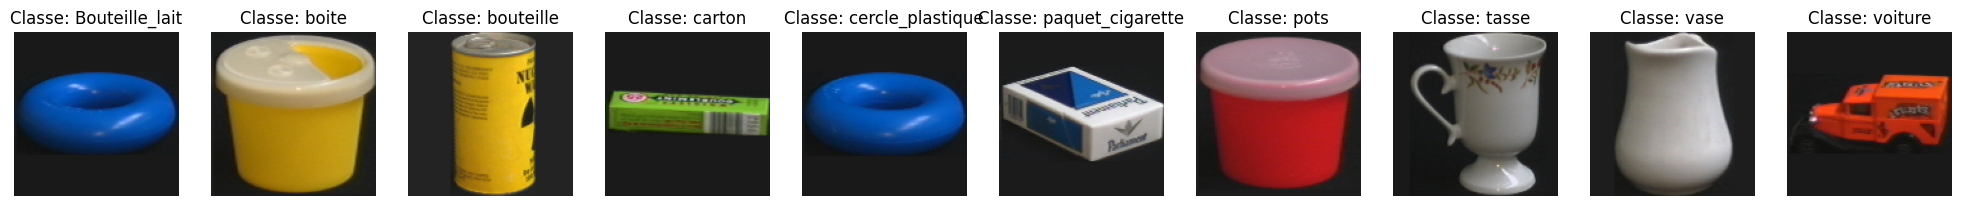

In [4]:
# Charger les images
image_data = load_custom_images(data_path)

# Afficher les classes chargées
print(f" {len(image_data)} classes chargées : {list(image_data.keys())}")

# Afficher quelques images
fig, axs = plt.subplots(1, 10, figsize=(25, 12))
for i, (label, paths) in enumerate(image_data.items()):
    if i >= 10: break
    img = cv2.imread(paths[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(f"Classe: {label}")
    axs[i].axis("off")
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#  Détection SIFT
sift = cv2.SIFT_create()

def detect_sift_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return img, keypoints, descriptors



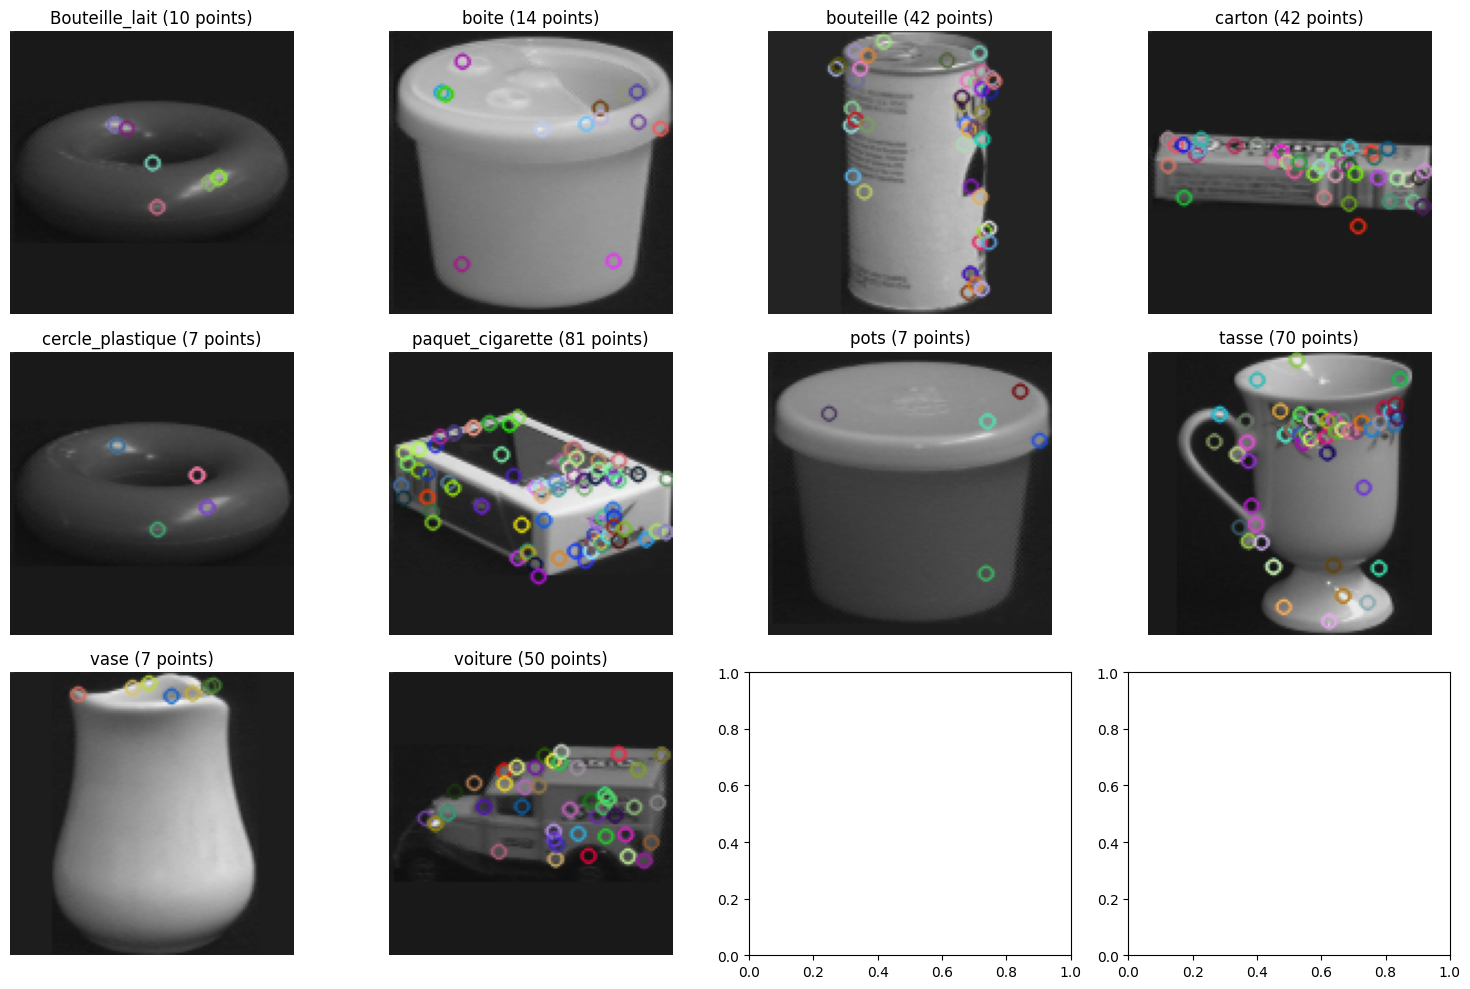

In [9]:
# Tester sur une image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=(len(image_data) // 4) + 1, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, (sample_class, img_paths) in enumerate(image_data.items()):
    if img_paths:  # Vérifie s'il y a au moins une image dans la classe
        img_path = img_paths[0]  # Prend seulement la première image de la classe
        img, keypoints, descriptors = detect_sift_features(img_path)
        img_sift = cv2.drawKeypoints(img, keypoints, None)

        axes[i].imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{sample_class} ({len(keypoints)} points)")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


In [10]:
#  Mise en Correspondance (Matching)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

def match_objects(img1_path, img2_path):
    img1, kp1, des1 = detect_sift_features(img1_path)
    img2, kp2, des2 = detect_sift_features(img2_path)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:50]

    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None)
    return matched_img

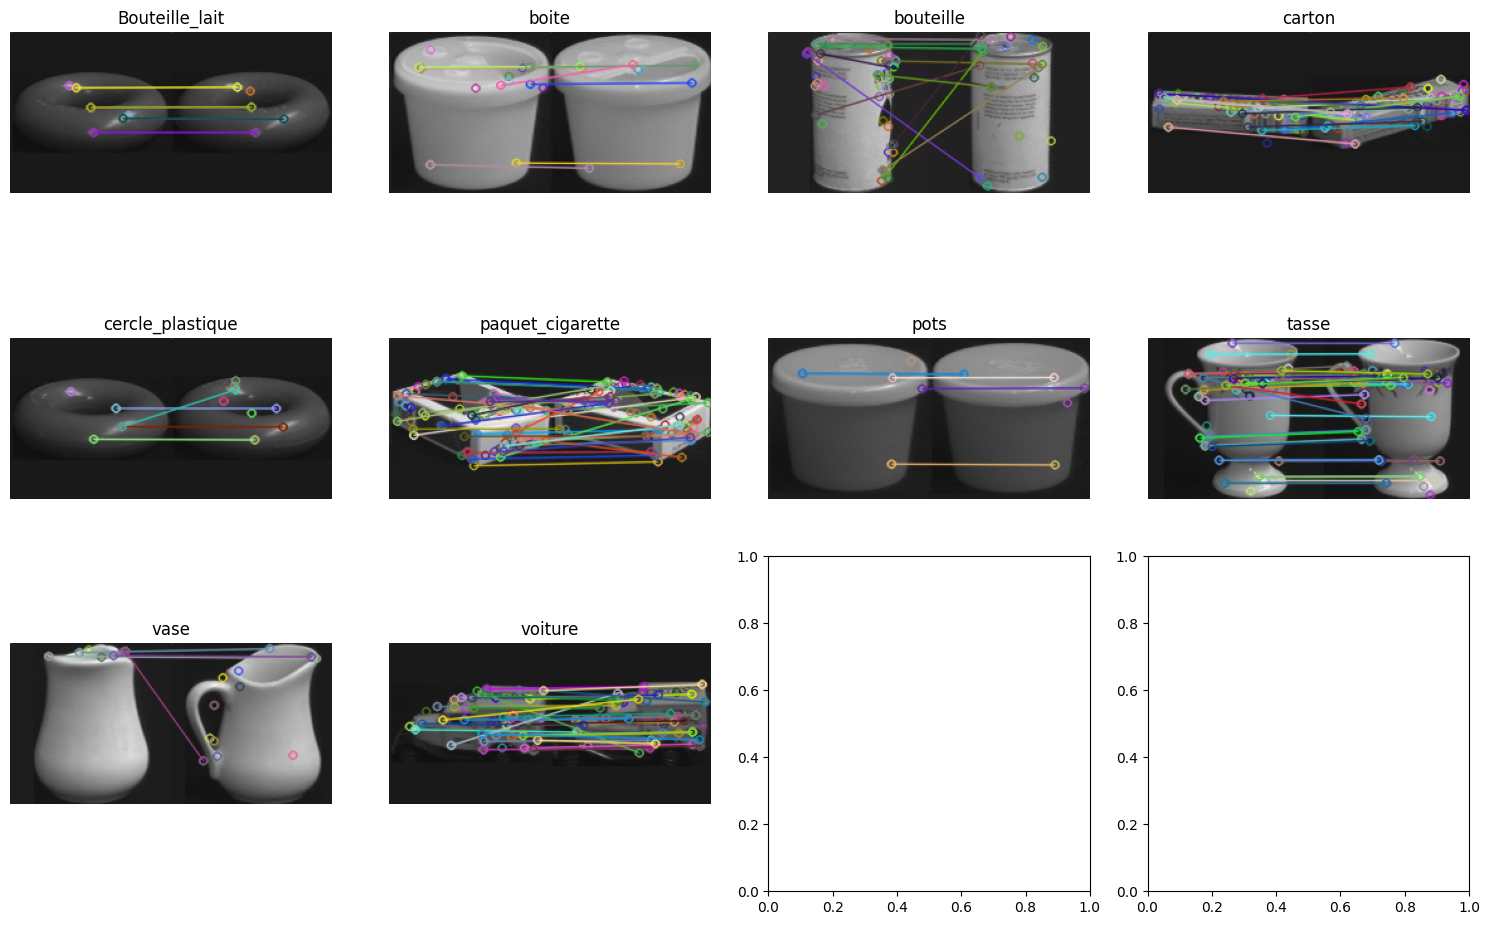

In [11]:
# Comparaison entre deux images de la même classe

fig, axes = plt.subplots(nrows=(len(image_data) // 4) + 1, ncols=4, figsize=(15, 10))
axes = axes.flatten()

idx = 0
for sample_class, img_paths in image_data.items():
    if len(img_paths) > 1 and idx < len(axes):
        img1_path = img_paths[0]
        img2_path = img_paths[1]
        matched_img = match_objects(img1_path, img2_path)

        axes[idx].imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f"{sample_class}")
        axes[idx].axis("off")
        idx += 1

plt.tight_layout()
plt.show()


In [12]:
# Reconnaissance d'un Objet Inconnu
def recognize_object(unknown_img_path, reference_images):
    best_match = None
    best_score = float("inf")

    for label, paths in reference_images.items():
        for ref_path in paths:
            img1, kp1, des1 = detect_sift_features(unknown_img_path)
            img2, kp2, des2 = detect_sift_features(ref_path)

            matches = bf.match(des1, des2)
            score = sum([m.distance for m in matches]) / len(matches) if matches else float("inf")

            if score < best_score:
                best_score = score
                best_match = label

    return best_match

In [13]:
# Tester avec une image inconnue
#sample_class = "carton"  # Test avec un objet de la classe "carton"
sample_class = "voiture"
unknown_img_path = image_data[sample_class][2]  # Prend une image de la base comme test
recognized_class = recognize_object(unknown_img_path, image_data)

print(f" L'objet inconnu est reconnu comme appartenant à la classe: {recognized_class}")


 L'objet inconnu est reconnu comme appartenant à la classe: voiture


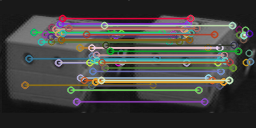

 Meilleure correspondance trouvée avec une image de la classe voiture.


In [14]:
# Afficher les correspondances entre l’image test et la classe prédite
def visualize_matching(unknown_img_path, recognized_class, reference_images):
    best_match_img = None
    best_score = float("inf")

    for ref_path in reference_images[recognized_class]:
        img1, kp1, des1 = detect_sift_features(unknown_img_path)
        img2, kp2, des2 = detect_sift_features(ref_path)

        matches = bf.match(des1, des2)
        score = sum([m.distance for m in matches]) / len(matches) if matches else float("inf")

        if score < best_score:
            best_score = score
            best_match_img = ref_path  # Sauvegarde la meilleure image correspondante

    # Affichage de la meilleure correspondance trouvée
    if best_match_img:
        matched_img = match_objects(unknown_img_path, best_match_img)
        cv2_imshow(matched_img)
        print(f" Meilleure correspondance trouvée avec une image de la classe {recognized_class}.")

#  Visualiser les correspondances après la reconnaissance
visualize_matching(unknown_img_path, recognized_class, image_data)


In [15]:
# Score de confiance basé sur la distance des descripteurs
def recognize_object_with_score(unknown_img_path, reference_images):
    best_match = None
    best_score = float("inf")

    scores = {}

    for label, paths in reference_images.items():
        for ref_path in paths:
            img1, kp1, des1 = detect_sift_features(unknown_img_path)
            img2, kp2, des2 = detect_sift_features(ref_path)

            matches = bf.match(des1, des2)
            score = sum([m.distance for m in matches]) / len(matches) if matches else float("inf")

            if label not in scores:
                scores[label] = []
            scores[label].append(score)

            if score < best_score:
                best_score = score
                best_match = label

    # Moyenne des scores par classe
    avg_scores = {label: sum(scores[label]) / len(scores[label]) for label in scores}

    return best_match, best_score, avg_scores

#  Tester la reconnaissance avec score
recognized_class, confidence_score, all_scores = recognize_object_with_score(unknown_img_path, image_data)

# Affichage des scores
print(f"L'objet inconnu est reconnu comme appartenant à la classe: {recognized_class}")
print(f" Score de confiance : {confidence_score:.2f} (plus bas = meilleure correspondance)")
print(f" Scores pour toutes les classes : {all_scores}")


L'objet inconnu est reconnu comme appartenant à la classe: voiture
 Score de confiance : 0.00 (plus bas = meilleure correspondance)
 Scores pour toutes les classes : {'Bouteille_lait': 366.4963515241045, 'boite': 320.2533861982531, 'bouteille': 337.87460659326314, 'carton': 330.18160607483344, 'cercle_plastique': 354.36248917769257, 'paquet_cigarette': 328.7979321984209, 'pots': 319.56370599232025, 'tasse': 365.7219820787225, 'vase': 353.6220038418629, 'voiture': 317.1612462581702}


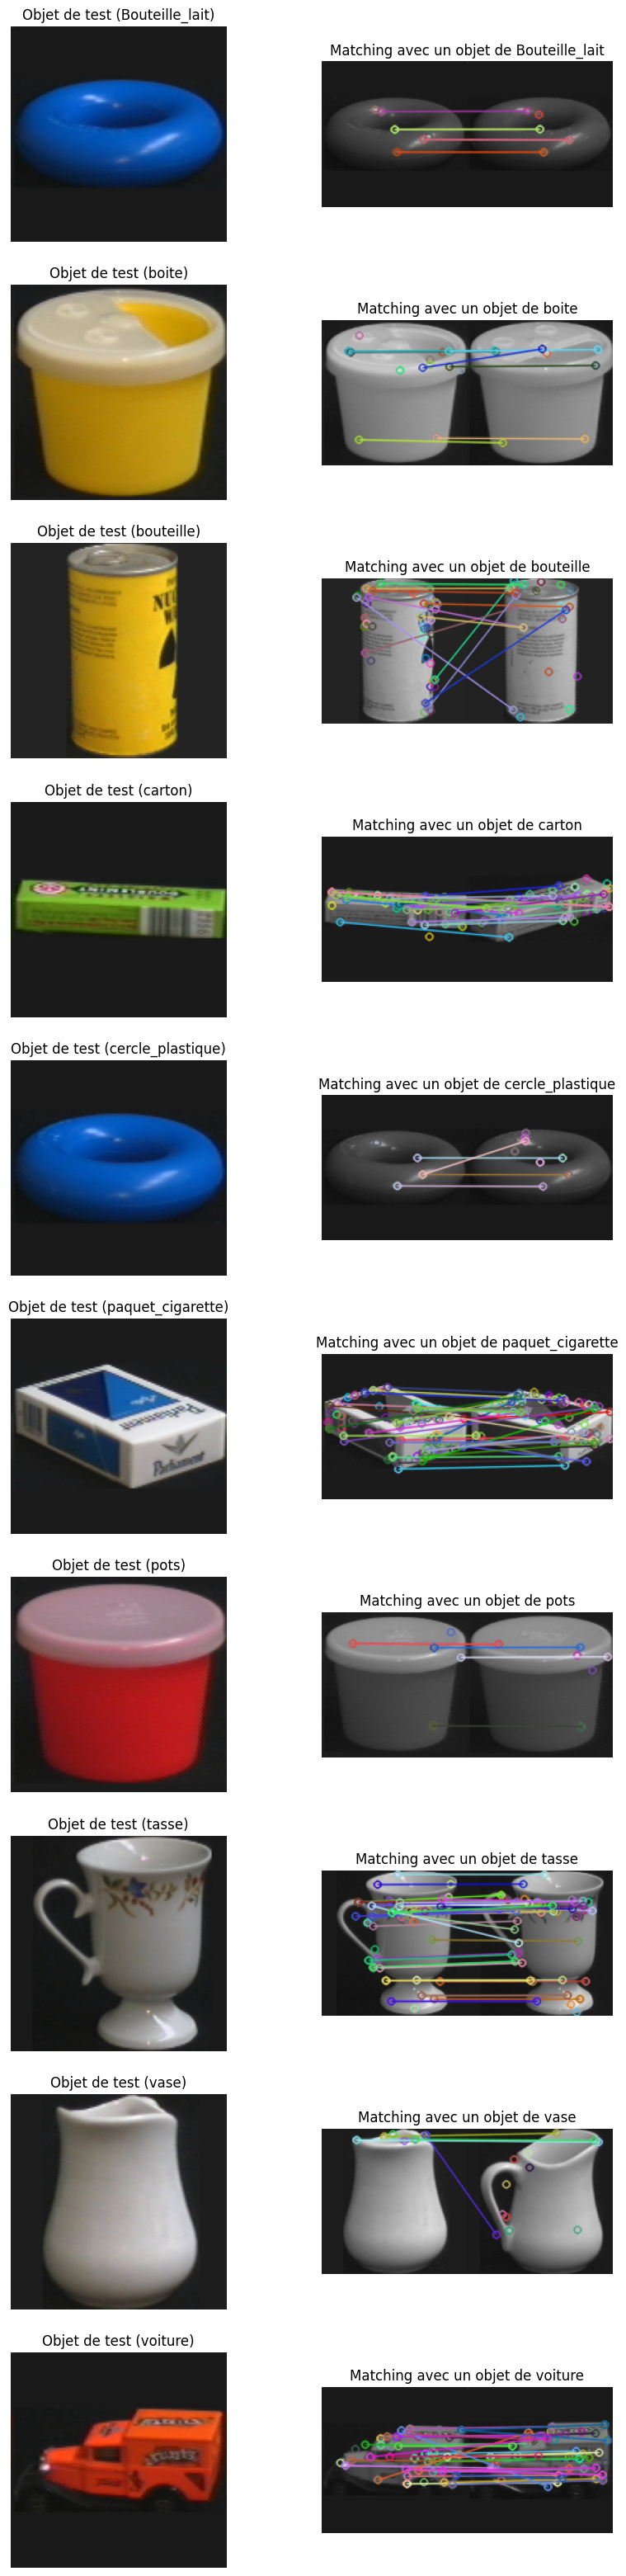

In [16]:
# Afficher les correspondances pour plusieurs objets
def test_multiple_objects(reference_images):
    fig, axs = plt.subplots(len(reference_images), 2, figsize=(10, len(reference_images) * 4))

    for i, (sample_class, image_paths) in enumerate(reference_images.items()):
        if len(image_paths) < 2:
            continue

        # Prendre une image de test et une de référence
        img1_path = image_paths[0]  # Image de test
        img2_path = image_paths[1]  # Image de comparaison

        # Faire le matching
        matched_img = match_objects(img1_path, img2_path)

        # Affichage
        axs[i, 0].imshow(cv2.imread(img1_path)[..., ::-1])
        axs[i, 0].set_title(f"Objet de test ({sample_class})")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(matched_img)
        axs[i, 1].set_title(f"Matching avec un objet de {sample_class}")
        axs[i, 1].axis("off")

    plt.show()

# Tester sur toutes les classes
test_multiple_objects(image_data)


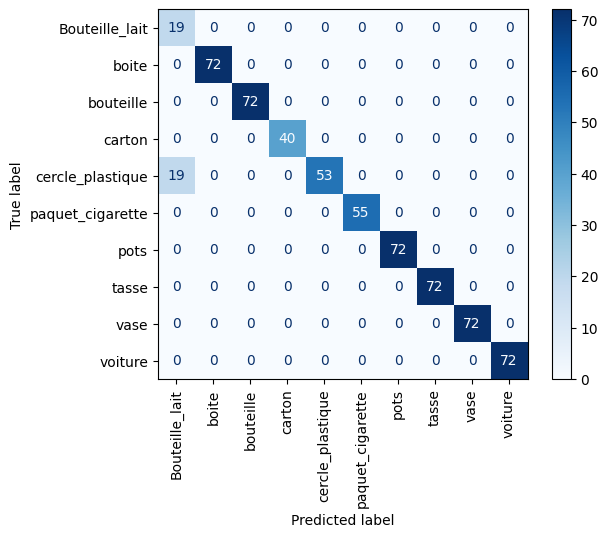

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

#  Générer une matrice de confusion
def compute_confusion_matrix(reference_images):
    true_labels = []
    predicted_labels = []

    for sample_class, image_paths in reference_images.items():
        for img_path in image_paths:
            recognized_class = recognize_object(img_path, reference_images)

            true_labels.append(sample_class)
            predicted_labels.append(recognized_class)

    # Créer la matrice
    labels = list(reference_images.keys())
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

    # Afficher la matrice
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.show()

# Calculer et afficher la matrice de confusion
compute_confusion_matrix(image_data)


In [ ]:
#  Remplacer SIFT par ORB
orb = cv2.ORB_create()

def detect_orb_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return img, keypoints, descriptors

# Comparaison avec SIFT
sample_img_path = image_data[sample_class][0]

sift_img, sift_kp, _ = detect_sift_features(sample_img_path)
orb_img, orb_kp, _ = detect_orb_features(sample_img_path)

print(f"SIFT : {len(sift_kp)} points détectés")
print(f"ORB  : {len(orb_kp)} points détectés")


SIFT : 96 points détectés
ORB  : 79 points détectés


In [ ]:
orb = cv2.ORB_create()

def detect_orb_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return img, keypoints, descriptors

# Tester SIFT vs ORB
sample_img_path = image_data["bouteille"][0]  # Remplace par n'importe quelle classe

sift_img, sift_kp, _ = detect_sift_features(sample_img_path)
orb_img, orb_kp, _ = detect_orb_features(sample_img_path)

print(f"SIFT : {len(sift_kp)} points détectés")
print(f"ORB  : {len(orb_kp)} points détectés")


SIFT : 120 points détectés
ORB  : 119 points détectés
